# MP1
By Anumita Dhobly & Lingjun Wen

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import OneClassSVM


from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

# Part 1

In [ ]:
# Load the Data from Github
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

# Using the same 7 features that was used by the paper
features = df[['age', 
                 'sex', 
                 'c_charge_desc',
                 'c_charge_degree', 
                 'priors_count', 
                 'juv_fel_count', 
                 'juv_misd_count']]

# One-hot encoding to make categorical features numerical
features = pd.get_dummies(features, columns=['c_charge_degree',
                                             'sex',
                                             'c_charge_desc'])

target = df['two_year_recid']

In [ ]:
# Train Test Split - using sklearn
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Processing Data - standardize data mean = 0, stddev = 1 -- to improve performance & stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# print(type(X_train))
# print("\n")


# Convert to tensors -- inputs for the pytorch model
X_train = torch.tensor(X_train, dtype=torch.float32)
# print(X_train.type)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1) # reshape to 1 col & however many rows needed (-1) 

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# n = X_train.shape[0] + X_test.shape[0]

In [ ]:
# Define Logistic Regression Model -- using nn.Module
class LogisticRegression(nn.Module): # new LogisticRegression class inherits from nn.Module
    def __init__(self, input_dim): # __init__ method with inout arguement input_dim
        # inhereit the methods and attributes of parent class
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1) # linear layer

    # computation "layer"
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x)) 
        return y_pred

In [ ]:
LRmodel = LogisticRegression(input_dim=X_train.shape[1]) # create the logistic regression model

# Define the loss function (binary cross-entropy) and optimizer (stochastic gradient descent)
criterion = nn.BCELoss()
optimizer = optim.SGD(LRmodel.parameters(), lr=0.01)


# Training
epochs = 1000
for epoch in tqdm(range(epochs)):
  LRmodel.train()

  y_pred = LRmodel(X_train)

  loss = criterion(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  LRmodel.eval()
  with torch.inference_mode():
    y_pred_test = LRmodel(X_test)
    
    test_loss = criterion(y_pred_test, y_test)
  
  if (epoch + 1) % 100 == 0:
      print(f"\nEpoch: [{epoch + 1}/{epochs}] | Training Loss: {loss:.5f} | Test loss: {test_loss:.5f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch: [100/1000] | Training Loss: 0.66768 | Test loss: 0.67126%

Epoch: [200/1000] | Training Loss: 0.63259 | Test loss: 0.65125%

Epoch: [300/1000] | Training Loss: 0.61184 | Test loss: 0.64039%

Epoch: [400/1000] | Training Loss: 0.59880 | Test loss: 0.63390%

Epoch: [500/1000] | Training Loss: 0.59025 | Test loss: 0.62980%

Epoch: [600/1000] | Training Loss: 0.58442 | Test loss: 0.62712%

Epoch: [700/1000] | Training Loss: 0.58030 | Test loss: 0.62533%

Epoch: [800/1000] | Training Loss: 0.57730 | Test loss: 0.62410%

Epoch: [900/1000] | Training Loss: 0.57506 | Test loss: 0.62325%

Epoch: [1000/1000] | Training Loss: 0.57335 | Test loss: 0.62266%


In [ ]:
# Predictions & Evaluate Model Performance
threshold = 0.5
with torch.no_grad():
    y_pred_test = LRmodel(X_test)
    y_pred_test = (y_pred_test > threshold).float().view(-1)
    accuracy = accuracy_score(y_test, y_pred_test)
    print("Accuracy:", accuracy)

Accuracy: 0.6611226611226612


### Calibration Curve & Brier Score

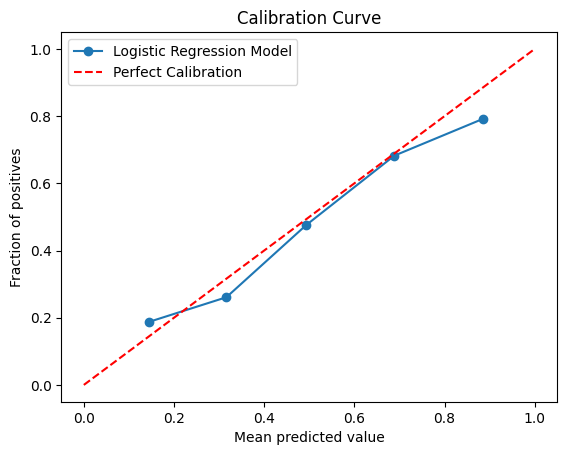

Brier Score: 0.21554309022116544


In [ ]:
# Plotting Calibration Curve & Calculate Brier Score to Evaluate Calibration
with torch.no_grad():
    y_pred_probs = LRmodel(X_test).numpy()

# Compute the calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test.numpy(), y_pred_probs, n_bins=5)

# Plot the calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linestyle='-', label='Logistic Regression Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect Calibration')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Calculate the Brier score
brier_score = brier_score_loss(y_test.numpy(), y_pred_probs)
print("Brier Score:", brier_score)

# Calculate the variance of the predicted probabilities
variance_pred_probs = np.var(y_pred_probs)
# std_dev_pred_probs = 2 * np.sqrt(2) * np.sqrt(variance_pred_probs)

# # Print the variance
# print(f"Variance of Predicted Probabilities: {variance_pred_probs:.4f}")
# print(f"Physics Requirement: \u00B1 {std_dev_pred_probs:.4f}")

The model does not satisfy the calibration curve exactly; however, with the low Brier score of approximately 0.22, the model seems to be well calibrated. Also, the predicted value of approximately 65.4 ~= 66.6 provided by the paper and is well within the range of 95% confidence values [64.4, 68.9] given by the paper. Therefore, we can say from this that at least the values measured are not significantly different from true proportions.

### False Positive Parity

In [ ]:
# Create a new DataFrame with race included
features_with_race = df[['age', 
                           'sex', 
                           'c_charge_desc',
                           'c_charge_degree', 
                           'priors_count', 
                           'juv_fel_count', 
                           'juv_misd_count',
                           'race']]

features_with_race = pd.get_dummies(features_with_race, columns=['c_charge_degree',
                                                                 'sex',
                                                                 'c_charge_desc'])

# Split the data into training and test sets with indices
__, X_test_race, __, y_test = train_test_split(features_with_race, target, test_size=0.2, random_state=42)

# Remove the 'race' column from X_test_race
X_test_without_race = X_test_race.drop(columns='race', errors='ignore')

# Standardize the test set without the 'race' column
X_test_without_race = scaler.transform(X_test_without_race)

# Convert X_test_without_race to tensor
X_test_without_race_tensor = torch.tensor(X_test_without_race, dtype=torch.float32)

# Make predictions on the test set using the PyTorch model
with torch.no_grad():
    y_pred_test_race = LRmodel(X_test_without_race_tensor).numpy()
    y_pred_probs =  y_pred_test_race.copy()
    y_pred_test_race = (y_pred_test_race > threshold).astype(int)

# Calculate the confusion matrix for each race
races = X_test_race['race'].unique()
false_positive_rates = {}

for race in races:
    race_indices = X_test_race[X_test_race['race'] == race].index
    race_positions = np.where(X_test_race.index.isin(race_indices))[0]  # Get the positions of the race indices
    y_test_race = y_test[race_indices].values
    y_pred_race = y_pred_test_race[race_positions]  # Use the positions instead of the actual indices

    tn, fp, fn, tp = confusion_matrix(y_test_race, y_pred_race).ravel()
    fpr = fp / (fp + tn)
    false_positive_rates[race] = fpr

# Print the false positive rates for each race
for race, fpr in false_positive_rates.items():
    if race == 'Caucasian' or race == 'African-American':
        print(f"{race}: False Positive Rate = {fpr:.2f}")

Caucasian: False Positive Rate = 0.18
African-American: False Positive Rate = 0.33


There clearly is a false positive rate disparity (aka false-positive rate parity is not satisfied) here, as the false positive rate for caucasian is approximately 0.18 (18%) and the false positive rate for african americans is approx 0.33 (33%), which is almost twice as much as their white counterparts.

In [ ]:
# Create a new DataFrame with race included
features_with_race = df[['age', 
                           'sex', 
                           'c_charge_desc',
                           'c_charge_degree', 
                           'priors_count', 
                           'juv_fel_count', 
                           'juv_misd_count',
                           'race']]

features_with_race = pd.get_dummies(features_with_race, columns=['c_charge_degree',
                                                                 'sex',
                                                                 'c_charge_desc'])

# Split the data into training and test sets with indices
__, X_test_race, __, y_test = train_test_split(features_with_race, target, test_size=0.2, random_state=42)

# Remove the 'race' column from X_test_race
X_test_without_race = X_test_race.drop(columns='race', errors='ignore')

# Standardize the test set without the 'race' column
X_test_without_race = scaler.transform(X_test_without_race)

# Convert X_test_without_race to tensor
X_test_without_race_tensor = torch.tensor(X_test_without_race, dtype=torch.float32)

# Make predictions on the test set using the LogisticRegression model
with torch.no_grad():
    y_pred_test_race = LRmodel(X_test_without_race_tensor).numpy()
    y_pred_probs =  y_pred_test_race.copy()

# Calculate the confusion matrix for each race
races = X_test_race['race'].unique()
false_positive_rates = {}

thresholds = [(0.585, 0.515, 0.5), (0.555, 0.495, 0.5)]

for threshold in thresholds:
    black_threshold, white_threshold, other_threshold = threshold
    print(f"black threshold: {black_threshold}\nwhite threshold: {white_threshold}\n")

    for race in races:
        race_indices = X_test_race[X_test_race['race'] == race].index
        race_positions = np.where(X_test_race.index.isin(race_indices))[0]  # Get the positions of the race indices
        y_test_race = y_test[race_indices].values
        
        if race == 'Caucasian':
            y_pred_race = (y_pred_test_race > white_threshold).astype(int)[race_positions]  # Use the positions instead of the actual indices
            accuracy = accuracy_score(y_test_race, y_pred_race)
            print("Caucasian Accuracy:", accuracy)
        
        elif race == 'African-American':
            y_pred_race = (y_pred_test_race > black_threshold).astype(int)[race_positions]  # Use the positions instead of the actual indices
            accuracy = accuracy_score(y_test_race, y_pred_race)
            print("Black Accuracy:", accuracy)
        
        else:
            y_pred_race = (y_pred_test_race > other_threshold).astype(int)[race_positions]

            

        tn, fp, fn, tp = confusion_matrix(y_test_race, y_pred_race).ravel()
        fpr = fp / (fp + tn)
        false_positive_rates[race] = fpr

    # Print the false positive rates for each race
    for race, fpr in false_positive_rates.items():
        if race == 'Caucasian' or race == 'African-American':
            print(f"{race}: False Positive Rate = {fpr:.2f}")
    print("\n\n")

black threshold: 0.585
white threshold: 0.515

Caucasian Accuracy: 0.6831683168316832
Black Accuracy: 0.6265389876880985
Caucasian: False Positive Rate = 0.15
African-American: False Positive Rate = 0.17



black threshold: 0.555
white threshold: 0.495

Caucasian Accuracy: 0.6712871287128713
Black Accuracy: 0.6388508891928865
Caucasian: False Positive Rate = 0.20
African-American: False Positive Rate = 0.20





two possible choices for thresholds:

(black_threshold1, white_threshold1) = (0.585, 0.515)

white accuracy ≈ 67%

black_accuracy ≈ 62%

white FPR ≈ 16%

black FPR ≈ 17%

black_threshold2, white_threshold2 = (0.555, 0.495)

white accuracy ≈ 67%

black_accuracy ≈ 63%

white FPR ≈ 20%

black FPR ≈ 20%

# Part 2

In [ ]:
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])

df['c_charge_desc'] = df['c_charge_desc'].replace(np.nan, 'none')

df.loc[df["sex"] == "Male", "sex"] = 1
df.loc[df["sex"] == "Female", "sex"] = 0

df.loc[df["c_charge_degree"] == "M", "c_charge_degree"] = 0
df.loc[df["c_charge_degree"] == "F", "c_charge_degree"] = 1

df = df.astype({'sex':'int', 'c_charge_degree':'int'})

In [ ]:
columns = ['id', 'is_recid',
           'sex','age','priors_count',
           'c_charge_desc','c_charge_degree','c_jail_in','c_jail_out']
           
df2 = df[columns].set_index('id')

df2['c_jail_in'] = df2['c_jail_in'].dt.date
df2['c_jail_out'] = df2['c_jail_out'].dt.date

df2['c_jail_time'] = df2['c_jail_out'] - df2['c_jail_in']

df2['c_jail_time'] = df2['c_jail_time'].dt.days.astype('float32')

df2['c_charge_desc'] = df2['c_charge_desc'].replace(np.nan, 'none')
df2['c_jail_time'] = df2['c_jail_time'].replace(np.nan, 0.0)

df2.head()

,is_recid,sex,age,priors_count,c_charge_desc,c_charge_degree,c_jail_in,c_jail_out,c_jail_time
id,,,,,,,,,
1,0,1,69,0,Aggravated Assault w/Firearm,1,2013-08-13,2013-08-14,1.0
3,1,1,34,0,Felony Battery w/Prior Convict,1,2013-01-26,2013-02-05,10.0
4,1,1,24,4,Possession of Cocaine,1,2013-04-13,2013-04-14,1.0
5,0,1,23,1,Possession of Cannabis,1,NaT,NaT,0.0
6,0,1,43,2,arrest case no charge,1,NaT,NaT,0.0


In [ ]:
charge_dummies = pd.get_dummies(df2.c_charge_desc)
df2 = pd.concat([df2, charge_dummies], axis=1)
df2.head()

,is_recid,sex,age,priors_count,c_charge_desc,c_charge_degree,c_jail_in,c_jail_out,c_jail_time,Abuse Without Great Harm,...,Viol Injunct Domestic Violence,Viol Injunction Protect Dom Vi,Viol Pretrial Release Dom Viol,Viol Prot Injunc Repeat Viol,Violation License Restrictions,Violation Of Boater Safety Id,Violation of Injunction Order/Stalking/Cyberstalking,Voyeurism,arrest case no charge,none
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,69,0,Aggravated Assault w/Firearm,1,2013-08-13,2013-08-14,1.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,34,0,Felony Battery w/Prior Convict,1,2013-01-26,2013-02-05,10.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,24,4,Possession of Cocaine,1,2013-04-13,2013-04-14,1.0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,23,1,Possession of Cannabis,1,NaT,NaT,0.0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,43,2,arrest case no charge,1,NaT,NaT,0.0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df2 = df2.drop(columns=['c_jail_in', 'c_jail_out', 'c_charge_desc'])
df2.head()

,is_recid,sex,age,priors_count,c_charge_degree,c_jail_time,Abuse Without Great Harm,Accessory After the Fact,Agg Abuse Elderlly/Disabled Adult,Agg Assault Law Enforc Officer,...,Viol Injunct Domestic Violence,Viol Injunction Protect Dom Vi,Viol Pretrial Release Dom Viol,Viol Prot Injunc Repeat Viol,Violation License Restrictions,Violation Of Boater Safety Id,Violation of Injunction Order/Stalking/Cyberstalking,Voyeurism,arrest case no charge,none
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,69,0,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,34,0,1,10.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,24,4,1,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,23,1,1,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,43,2,1,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
columns = df2.columns.tolist()
print(columns)
features = columns[2:]
targets = columns[:2]
print(features)
print(targets)

['is_recid', 'sex', 'age', 'priors_count', 'c_charge_degree', 'c_jail_time', 'Abuse Without Great Harm', 'Accessory After the Fact', 'Agg Abuse Elderlly/Disabled Adult', 'Agg Assault Law Enforc Officer', 'Agg Assault W/int Com Fel Dome', 'Agg Battery Grt/Bod/Harm', 'Agg Fleeing and Eluding', 'Agg Fleeing/Eluding High Speed', 'Aggr Child Abuse-Torture,Punish', 'Aggrav Battery w/Deadly Weapon', 'Aggrav Child Abuse-Agg Battery', 'Aggrav Child Abuse-Causes Harm', 'Aggrav Stalking After Injunctn', 'Aggravated Assault', 'Aggravated Assault W/Dead Weap', 'Aggravated Assault W/dead Weap', 'Aggravated Assault W/o Firearm', 'Aggravated Assault w/Firearm', 'Aggravated Battery', 'Aggravated Battery (Firearm)', 'Aggravated Battery (Firearm/Actual Possession)', 'Aggravated Battery / Pregnant', 'Aggravated Battery On 65/Older', 'Aggress/Panhandle/Beg/Solict', 'Aide/Abet Prostitution Lewdness', 'Aiding Escape', 'Alcoholic Beverage Violation-FL', 'Armed Trafficking in Cannabis', 'Arson II (Vehicle)', '

In [ ]:
x_vals = df2[features].to_numpy()
y_vals = df2[targets].to_numpy()

#print(len(x_vals))
#print(len(y_vals))

In [ ]:
x = torch.tensor(x_vals)
y = torch.tensor(y_vals)

In [ ]:
x = x.to(torch.float32)
y = y.to(torch.float32)

In [ ]:
#print(len(x))
#print(len(y))

In [ ]:
in_dim = len(x[0])
#print(in_dim)

In [ ]:
x_train, x_non_test, y_train, y_non_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_non_test, y_non_test, test_size=0.5, shuffle = True, random_state=42)
#print(len(x_train), len(x_val), len(x_test), len(y_train), len(y_val), len(y_test))

In [ ]:
y_train_r = y_train[:, 0]
y_train_s = y_train[:, 1]

y_val_r = y_val[:, 0]
y_val_s = y_val[:, 1]

y_test_r = y_test[:, 0]
y_test_s = y_test[:, 1]

#print(len(y_train_r))
#print(len(y_train_s))

#print(len(y_val_r))
#print(len(y_val_s))

#print(len(y_test_r))
#print(len(y_test_s))

### Feataure choics

The following features were chosen:


*   age
*   sex
*   priors_count
*   c_jail_in
*   c_jail_out
*   c_charge_desc
*   c_charge_degree


Age, sex and number of priors were chosen as they have been determined to be the most predictive features. The features c_jail_in and c_jail_out were combined to create a new feature: c_jail_time, where c_jail_time = c_jail_out - c_jail_in. This feature shows the amount of time spent by the person in jail, in days. c_charge_desc shows the description of the crime committed - this feature is one-hot encoded before being run through the model. Finally, c_charge_degree gives the degree of the crime (felony or misdemeanor). As this feature is a binary variable, it was converted to values of 0’s and 1’s. 

This set of features seems to result in better performance when compared to the model in part 1. 


### Creating mini-batches for training

In [ ]:
clf = OneClassSVM(gamma='auto').fit(x_train)

In [ ]:
scores = (clf.score_samples(x_train))

In [ ]:
print(np.max(scores), np.min(scores))

1010.559839198784 1.0


In [ ]:
print(scores.shape)

(5771,)


In [ ]:
batch_size = 512
num_batches = int(len(x_train)/batch_size) + 1

In [ ]:
print(x_train.shape)

torch.Size([5771, 442])


In [ ]:
print(num_batches)

12


In [ ]:
def get_minibatch(x_train, y_train_r, y_train_s, taken, scores, batch_size):
  x_minibatch = []
  y_r_minibatch = []
  y_s_minibatch = []

  for i in (range(batch_size)):

    if (np.where(taken==0)[0].shape)[0] == 0: break

    x_train_temp = x_train[np.where(taken == 0)] 
    y_train_r_temp = y_train_r[np.where(taken == 0)] 
    y_train_s_temp = y_train_s[np.where(taken == 0)] 
    scores_temp = scores[np.where(taken == 0)] 

    if i % 2 == 0:
      ind = np.argmin(scores_temp)

    else: 
      ind = np.argmax(scores_temp)

    x_minibatch.append(x_train[ind])
    y_r_minibatch.append(y_train_r[ind])
    y_s_minibatch.append(y_train_s[ind])

    t_ind = np.where((scores == scores_temp[ind]) & (taken == 0))[0][0]

    #print(t_ind)

    indices.append(t_ind)

    taken[t_ind] = 1

  return torch.stack(x_minibatch), torch.stack(y_r_minibatch), torch.stack(y_s_minibatch), taken

In [ ]:
taken = np.zeros(scores.shape)
indices = []

x_train_batches = []
y_train_r_batches = []
y_train_s_batches = []

for i in tqdm(range(num_batches)):
  #print(i)
  x_mb, y_r_mb, y_s_mb, taken = get_minibatch(x_train, y_train_r, y_train_s, taken, scores, batch_size)

  x_train_batches.append(x_mb)
  y_train_r_batches.append(y_r_mb)
  y_train_s_batches.append(y_s_mb)

  #print(np.where(taken==0)[0].shape, np.where(taken==1)[0].shape)
  #print(len(indices), (i+1)*512)

  #break

  0%|          | 0/12 [00:00<?, ?it/s]

### Create model and training

In [ ]:
class WW_predictor(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(in_dim, 256)
    self.l2 = nn.Linear(256, 128)

    self.x = nn.Linear(128, 64)
    
    self.lout_r = nn.Linear(64, 1)
    self.lout_s = nn.Linear(64, 1)

    nn.init.xavier_uniform_(self.l1.weight)
    nn.init.xavier_uniform_(self.l2.weight)
    nn.init.xavier_uniform_(self.x.weight)
    nn.init.xavier_uniform_(self.lout_r.weight)
    nn.init.xavier_uniform_(self.lout_s.weight)


  def forward(self, in_):
    y = self.l1(in_)
    y = self.l2(y)

    y = self.x(y)

    r_pred = torch.sigmoid(self.lout_r(y))
    s_pred = torch.sigmoid(self.lout_s(y))

    return r_pred, s_pred

In [ ]:
WWmodel = WW_predictor()
WWmodel

WW_predictor(
  (l1): Linear(in_features=442, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (x): Linear(in_features=128, out_features=64, bias=True)
  (lout_r): Linear(in_features=64, out_features=1, bias=True)
  (lout_s): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(WWmodel.parameters(), lr=0.001)

In [ ]:
def acc_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
path = "model.pt"

In [ ]:
epochs = 1000

val_acc_list = []
val_loss_list = []

for epoch in tqdm(range(int(epochs)), desc='epochs'):
  for i in range(num_batches):
    x_train_batch = x_train_batches[i]
    y_train_r_batch = y_train_r_batches[i]
    y_train_s_batch = y_train_s_batches[i]

    if len(x_train_batch) == 0: break

    WWmodel.train()

    r_logits, s_logits = WWmodel(x_train_batch)

    r_logits = r_logits.squeeze()
    s_logits = s_logits.squeeze()
    
    r_pred = torch.round(r_logits)
    s_pred = torch.round(s_logits)

    r_loss = loss_fn(r_logits, y_train_r_batch)
    s_loss = loss_fn(s_logits, y_train_s_batch)

    loss = r_loss + (1/s_loss) # divide by s_loss will punish the model for predicting sex correctly (1/small loss value = a large loss value)



    acc = acc_fn(y_train_r_batch, r_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  WWmodel.eval()
  with torch.inference_mode():
    r_val_logits, s_val_logits = WWmodel(x_val)

    r_val_logits = r_val_logits.squeeze()
    s_val_logits = s_val_logits.squeeze()

    r_val_pred = torch.round(r_val_logits)
    s_val_pred = torch.round(s_val_logits)
    
    r_val_loss = loss_fn(r_val_logits, y_val_r)
    s_val_loss = loss_fn(s_val_logits, y_val_s)

    val_loss = r_val_loss + (1/s_val_loss)

    val_acc = acc_fn(y_val_r, r_val_pred)

    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

  if len(val_loss_list) >= 3 and (val_loss_list[-3] <= val_loss_list[-2] <= val_loss_list[-1]):
    print(f"\nEARLY STOPPING\n\tEpoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")
    print(val_loss_list)
    print(val_acc_list)
    break


  if epoch%500 == 0 or epoch == epochs-1:
    print(f"\nEpoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

epochs:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch: 0 | Loss: 3.69833, Accuracy: 58.27% | Validation loss: 4.78393, Validation acc: 64.77%

EARLY STOPPING
	Epoch: 13 | Loss: 0.65745, Accuracy: 63.31% | Validation loss: 0.63555, Validation acc: 67.68%
[tensor(4.7839), tensor(1.2044), tensor(0.7063), tensor(0.9004), tensor(0.7178), tensor(0.6575), tensor(0.6535), tensor(0.6478), tensor(0.6406), tensor(0.6367), tensor(0.6355), tensor(0.6350), tensor(0.6350), tensor(0.6355)]
[64.77115117891817, 44.79889042995839, 65.0485436893204, 44.79889042995839, 59.77808599167822, 67.40638002773926, 67.82246879334258, 66.99029126213593, 67.96116504854369, 67.68377253814147, 67.68377253814147, 67.54507628294036, 67.26768377253815, 67.68377253814147]


### Tuning playbook choices:

The following strategies from the fine-tuning handbook were chosen: 
Early stopping
Used adam instead of sgd
Batches 

The following strategies were considered but not chosen:
Initial model architecture
Incremental tuning

Initial model architecture was not chosen as in this situation, the only way to change the model architecture is to change the number of hidden layers. However, since adding hidden layers will increase computational time and effort with no guarantee in improved model performance, this strategy was not chosen. 

Incremental tuning was also considered as a potential strategy, however, this option would require  the model would need to be retrained with new hyperparameter values several times. As this can be very time and computationally intensive, this strategy was not chosen. 


### Predicting

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
WWmodel.x.register_forward_hook(get_activation('x'))

In [ ]:
WWmodel.eval()

r_pred_logits, s_pred_logits = WWmodel(x_test)

FEATS = []
FEATS.append(activation['x'].cpu().numpy())

r_pred = torch.round(r_pred_logits.squeeze())
s_pred = torch.round(s_pred_logits.squeeze())

print("acuracy of test set: ", acc_fn(y_test_r, r_pred))

acuracy of test set:  63.850415512465375


In [ ]:
r_pred = r_pred.cpu().detach().numpy()
s_pred = s_pred.cpu().detach().numpy()

In [ ]:
r_pred_logits = r_pred_logits.cpu().detach().numpy()
s_pred_logits = s_pred_logits.cpu().detach().numpy()

### Proving mode collapse

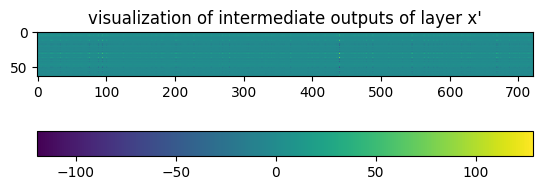

In [ ]:
plt.imshow(FEATS[0].transpose()) # rotated for ease of viewing
plt.colorbar(orientation='horizontal')
#plt.clim(-10, 10)
plt.title("visualization of intermediate outputs of layer x'")
plt.show()

In the plot above, each intermediate output for the layer x' for each piece of testing data is shown as a a colored vertical line (the intermediate output for the first input is a vertical line at 0, the intermediate output for the last output is a vertical line at 722). 

Based on the plot above, it can be seen that the majority of the intermediate outputs for layer x' are approximately zero vectors, and there is very little variation across the different inputs (if I were to draw a horizontal line across the plot, there is almost no variation in color along this line). 

This means that for each of the 722 inputs, the x' layer outputs approximately the same vector each time. This means that regardless of the input to the model, the outputs for the model will be approximately the same each time, thus indicating mode collapse.  

# Part 3

***In the context of recidivism prediction for COMPAS, present an argument in favour of aiming for demographic parity.***

It prevents people from being wrongly convicted (false-positive) just because they belong to a certain demographic. Conversely, it prevents freeing actually dangerous people just because they belong to a certain demographic. 

***In the context of recidivism prediction for COMPAS, present an argument in favour of aiming for false-positive parity.***

Aiming for false-positive parity ensures that people across every demographic have equal probability of being falsely classified as future offenders. This has several benefits, but mainly this ensures fairness across demographics and equal treatment, such that no demographic is unjustly penalized simply due to their racial profile. In the long term, this can mitigate the unevenly distributed incarceration rates in the US for different ethnicities, contributing to reducing systematic biases in the justice system.

***In the context of recidivism prediction for COMPAS, present an argument in favour of aiming for calibration.***

Calibration ensures that the model does not over-forecast or under-forecast. In other words, it ensures that the probabilities computed by the model is as close to ideal as possible - thus ensuring that the outputs are not biased (the predictions and the observed relative frequency of occurrences match). 

***In the context of recidivism prediction for COMPAS, consider Sharad Goel’s concepts of aggregate social welfare, and aggregate social welfare as computed for each demographic separately. Make one argument in favour of using those concepts. Make two arguments against those thinking that those concepts should guide the design of systems; at least one of those arguments should be specific to the aggregate social welfare as computed for each demographic separately.***

Using such concepts prioritizes the social welfare of each individual demographic. The social welfare for each individual demographic will accumulate, and will help improve the overall social welfare of the population. This tries to ensure that no demographic is worse off than any other demographic, and that the benefit to each demographic is maximized without harming other demographics. 

However, by trying to maximize the social welfare to each individual demographic, the aggregate social welfare to the entire population may in fact not be maximized. If a certain demographic does indeed have a higher percentage of dangerous people, for the welfare of the entire population, it is more important to correctly convict these people instead of trying to maximize social welfare for their demographic. For example, if a certain demographic has a higher percentage of people who instigate shootings, it is in the best interest of the entire population to ensure that those suspected to instigate shootings are detained. Even if it is wrongfully so, the harm done by a shooting severely outweighs the harm done by a few wrong detainments. 

Additionally, such measures could also encourage more false negatives which can overall be more dangerous. The model will wrongly classify people to not be a danger to the public, which means that people who might actually be dangerous will not be flagged by the model, thus giving these people more freedom to potentially commit more crimes. Overall, the aggregate welfare to society will once again not be maximized. 

On the other hand, using demographic specific measures for social welfare could potentially lead to maximizing overall social benefits across all demographics, as the social welfare for each individual demographic accumulates. This approach not only ensures reducing recidivism rates for each demographic, but it also ensures that equitable outcomes acorss all demographics, leading to a more just and efficient legal system and society.

However, it is often difficult to measure or quantify what is considered social welfare. In general, determining the cprrect weights and outcomes is a complex task and often depends on subjective judgment that differs from person to person, especially across different socio-economic, political, and religious spectrums. On a similar note, trade-offs involved between competing social outcomes are equally difficult to measure. As a result, quantification of social welfare can lead to suboptimal results.

Enforcing demographic specific outcomes can lead to unintended consequences. Such measures could encourage more false negatives for certain demographics that can lead to more dangerous outcomes. It can also enforce existing biases or create new ones, which may falsely create an false illusion of betterment at the detriment of a certain demographic.

***There are many contexts in which prediction systems are currently being used. Examples include credit scores; university admissions; insurance rate offers; early-warning systems for deteriorating patients in hospital. Pick one field (not necessarily one of the ones I listed) where you think the ethical considerations are different from the ethical considerations for COMPAS. Argue that the ethical considerations for the two cases are different, and connect your argument to observational and causal measures of fairness that we discussed in class.***

In university admissions, the ethical considerations are significantly different from COMPAS. 

The aim of COMPAS is to ensure that dangerous people are kept under control and do not harm others. False-positives could ruin a person’s life. If a person is wrongly flagged, they will be punished for no reason, and security efforts will also be wasted on a person who is of no danger to the public. Meanwhile, false-negatives could also be disastrous as it would mean that dangerous people will be allowed to roam free where they can do as much harm as they wish. 

On the other hand, university admissions have considerably lower stakes than COMPAS. In this case, false-positives (people admitted who do not deserve it) and false negatives (people rejected when they should have been admitted) do not have disastrous results. People who did not deserve admission will automatically be weeded out within the first year of university if they genuinely do not have the capability to keep up. While those who do deserve admission at a specific university still have the opportunity to receive their education at a different university. Personally, I have never heard of anyone who is rejected from every university they apply to; most people get into their safety school at the very least or are presented opportunities for advancement later on. However, it is also known that many demographics tend to be under-represented in certain fields (for example, not enough women in stem). This will have negative effects on the general population as it would result in such fields not taking needs of under-represented demographics into consideration. For example, if there are too many male medical researchers, not enough research would be done on women, leading to men having better healthcare than women. 


Essentially, COMPAS needs to ensure that only dangerous people are flagged, regardless of their demographic. However, false negatives could have very serious and very obvious consequences. Meanwhile, university admissions need to ensure that everyone who is qualified gets an opportunity, while also ensuring that there is diversity amongst their students. False predictions (incorrectly admitted or rejected) do not have extremely disastrous results on the large scale. However, not considering demographics during predictions could allow the damage done by previous generations to perpetuate, resulting in serious but not as obvious consequences. 
